Part 2 - Deep Learning and Clustering of Image Data

QUESTION 19: In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?

VGG exhibits key characteristics, including a deep architecture, utilization of small-sized convolutional kernels, and a combination of convolutional, pooling, and fully connected layers. This structural design empowers the network to grasp intricate features within images. The adaptability of VGG makes it particularly effective for feature extraction across diverse datasets, aligning seamlessly with the principles of transfer learning. Consequently, the features derived from VGG networks prove advantageous for feature extraction and discrimination in other datasets.

In [112]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.metrics.cluster import rand_score
from sklearn.decomposition import TruncatedSVD
!pip install umap-learn
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
!pip install hdbscan
import hdbscan
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split


# Flowers Dataset and VGG Features

In [41]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            print(x.shape)
            out = self.features(x)
            print(out.shape)
            out = self.pooling(out)
            print(out.shape)
            out = self.flatten(out)
            print(out.shape)
            out = self.fc(out)
            print(out.shape)
            print("\n The number of zero value is:",4096*out.shape[0]-np.count_nonzero(out.cpu().numpy()))
            print()
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
  0%|          | 0/58 [00:00<?, ?it/s]

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  2%|▏         | 1/58 [00:00<00:34,  1.65it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  3%|▎         | 2/58 [00:01<00:32,  1.73it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  5%|▌         | 3/58 [00:01<00:31,  1.72it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  7%|▋         | 4/58 [00:02<00:30,  1.75it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  9%|▊         | 5/58 [00:02<00:30,  1.75it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 10%|█         | 6/58 [00:03<00:29,  1.76it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 12%|█▏        | 7/58 [00:04<00:29,  1.75it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 14%|█▍        | 8/58 [00:04<00:28,  1.76it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 16%|█▌        | 9/58 [00:05<00:27,  1.76it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 17%|█▋        | 10/58 [00:05<00:27,  1.76it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 19%|█▉        | 11/58 [00:06<00:26,  1.74it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 21%|██        | 12/58 [00:06<00:26,  1.73it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 22%|██▏       | 13/58 [00:07<00:25,  1.74it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 24%|██▍       | 14/58 [00:08<00:26,  1.64it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 26%|██▌       | 15/58 [00:08<00:29,  1.48it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 28%|██▊       | 16/58 [00:10<00:36,  1.14it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 29%|██▉       | 17/58 [00:11<00:34,  1.19it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 31%|███       | 18/58 [00:11<00:33,  1.20it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 33%|███▎      | 19/58 [00:12<00:32,  1.20it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 34%|███▍      | 20/58 [00:13<00:32,  1.15it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 36%|███▌      | 21/58 [00:14<00:35,  1.04it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 38%|███▊      | 22/58 [00:15<00:30,  1.17it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 40%|███▉      | 23/58 [00:16<00:27,  1.28it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 41%|████▏     | 24/58 [00:16<00:24,  1.37it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 43%|████▎     | 25/58 [00:17<00:22,  1.45it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 45%|████▍     | 26/58 [00:17<00:21,  1.51it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 47%|████▋     | 27/58 [00:18<00:19,  1.56it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 48%|████▊     | 28/58 [00:19<00:18,  1.59it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 50%|█████     | 29/58 [00:19<00:18,  1.60it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 52%|█████▏    | 30/58 [00:20<00:17,  1.59it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 53%|█████▎    | 31/58 [00:21<00:17,  1.53it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 55%|█████▌    | 32/58 [00:21<00:17,  1.47it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 57%|█████▋    | 33/58 [00:22<00:16,  1.51it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 59%|█████▊    | 34/58 [00:22<00:15,  1.55it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 60%|██████    | 35/58 [00:23<00:14,  1.59it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 62%|██████▏   | 36/58 [00:24<00:13,  1.60it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 64%|██████▍   | 37/58 [00:24<00:12,  1.63it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 66%|██████▌   | 38/58 [00:25<00:12,  1.63it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 67%|██████▋   | 39/58 [00:25<00:11,  1.64it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 69%|██████▉   | 40/58 [00:26<00:10,  1.66it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 71%|███████   | 41/58 [00:27<00:10,  1.68it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 72%|███████▏  | 42/58 [00:27<00:09,  1.67it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 74%|███████▍  | 43/58 [00:28<00:08,  1.69it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 76%|███████▌  | 44/58 [00:28<00:08,  1.68it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 78%|███████▊  | 45/58 [00:29<00:07,  1.68it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 79%|███████▉  | 46/58 [00:30<00:07,  1.66it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 81%|████████  | 47/58 [00:30<00:06,  1.69it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 83%|████████▎ | 48/58 [00:31<00:05,  1.68it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 84%|████████▍ | 49/58 [00:31<00:05,  1.69it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 86%|████████▌ | 50/58 [00:32<00:05,  1.57it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 88%|████████▊ | 51/58 [00:33<00:04,  1.51it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 90%|████████▉ | 52/58 [00:34<00:04,  1.47it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 91%|█████████▏| 53/58 [00:34<00:03,  1.51it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 93%|█████████▎| 54/58 [00:35<00:02,  1.56it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 95%|█████████▍| 55/58 [00:35<00:01,  1.60it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 97%|█████████▋| 56/58 [00:36<00:01,  1.61it/s]


 The number of zero value is: 0

torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 98%|█████████▊| 57/58 [00:37<00:00,  1.62it/s]


 The number of zero value is: 0

torch.Size([22, 3, 224, 224])
torch.Size([22, 512, 7, 7])
torch.Size([22, 512, 7, 7])
torch.Size([22, 25088])
torch.Size([22, 4096])


100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


 The number of zero value is: 0



QUESTION 20: In a brief paragraph explain how the helper code base is performing feature extraction.

The feature extraction is done by
1. Extract VGG-16's feature layers.
2. Encapsulate the extracted list of convolutional layers into 'nn.Sequential' module, faciliating their use in the forward pass of the model.
3. Extract the average pooling layer from the VGG-16 model to reduce the dimensionality of the feature maps.
4. Flatten the feature maps into a one-dimensional vector.
5. Extract the first layer from the fully connected layer of the VGG-16 model to be used as a linear layer for the final classification.

In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


QUESTION 21: How many pixels are there in the original images? How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample?

1. There are 3670 images in the dataset. The original images have being composed to the size of 224x224x3=150,528 pixels.

2. According to the output shape of the x, it could be seen that the features:
*   Dimension: 512x7x7 features for the execution of 'features', and 'pooling'
*   Dimension: 25,088 features for the execution of 'flatten'
*   Dimension: 4,096 features for the 'fc'

QUESTION 22: Are the extracted features dense or sparse? (Compare with sparse TF-IDF features in text.)

The extracted features dense. In theory, the TF-IDF features are typically sparse. In this extracted features, the dimension are being reduced from 150,528(224x224x3) to 25,088(512x7x7), and finally to 4,096. The dimensionality reduction operations usually do not lead to sparse matrices; rather, they may decrease the sparsity of the original data. According to the output of the 'out' from the code, we can observe that almost no zero values are shown in the feature vectors.

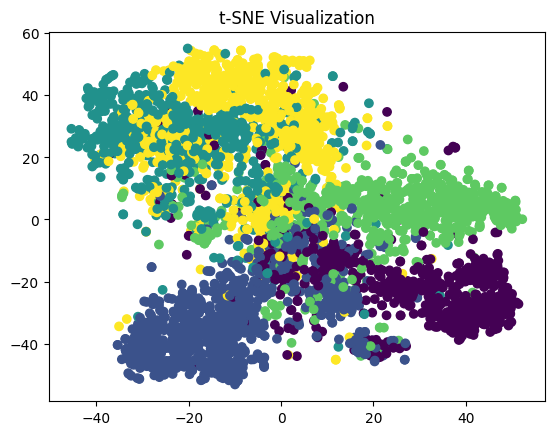

In [42]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(f_all)
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=y_all, cmap='viridis')
plt.title('t-SNE Visualization')
plt.show()

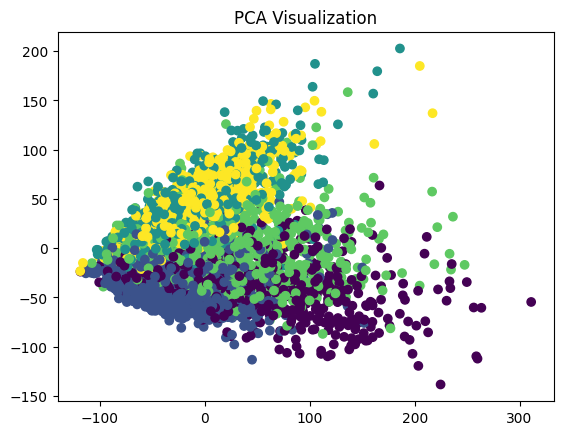

In [45]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)
plt.title('PCA Visualization')
plt.show()

# Autoencoder

In [43]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


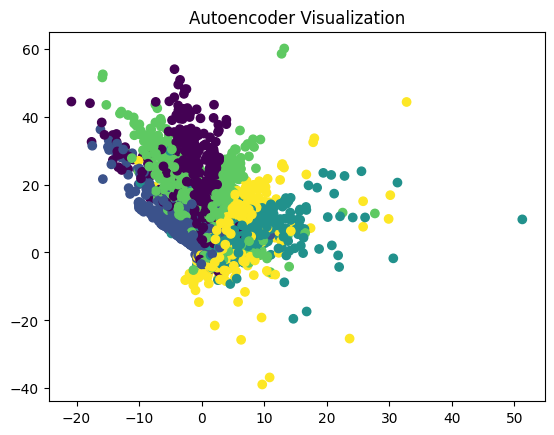

In [47]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)
plt.title('Autoencoder Visualization')
plt.show()

QUESTION 23: In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation.

While PCA is a powerful method for dimensionality reduction, it is limited to “linear” transformations. This might not be particularly good if a dataset is distributed non-linearly. An alternative approach is use of an “autoencoder” or UMAP. The helper has implemented an autoencoder which is ready to use.

T-SNE, PCA, and the Autoencoder have been used to reduce the dimensionality from 4096 dimensions to 2 dimensions. Notably, the t-SNE visualization reveals distinct clusters, effectively representing five clear groups. In contrast, the PCA visualization faces challenges in clearly distinguishing between these groups, highlighting the dataset's inherent nonlinearity. The Autoencoder also exhibits good separation of different groups in 2D visualization. However, an unexpected clustering phenomenon occurs where one cluster is encapsulated within another, indicating potential complexities in the underlying data structure.

Evaluating the trade-offs between these methods is crucial. While t-SNE excels in capturing intricate cluster patterns, PCA struggles with the dataset's nonlinearity. The Autoencoder, though generally effective, needs careful examination and potential adjustments to address the observed encapsulation issue.

QUESTION 24: Report the best result (in terms of rand score) within the table below. For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.

Dimensionality Reduction

None

In [48]:
np.savetxt('f_all.txt', f_all)
np.savetxt('y_all.txt', y_all)

SVD with r=50

In [56]:
svd_model = TruncatedSVD(n_components=50)
svd_features = svd_model.fit_transform(f_all)
np.savetxt('svd.txt', svd_features)

UMAP with n_components=50

In [57]:
umap_model = umap.UMAP(n_components=50)
umap_features = umap_model.fit_transform(f_all)
np.savetxt('umap.txt', umap_features)

Autoencoder with num_features=50

In [58]:
autoencoder_model = Autoencoder(50)
autoencoder_features = autoencoder_model.fit_transform(f_all)
np.savetxt('autoencoder.txt', autoencoder_features)

100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Clustering

K-Means with k=5

In [85]:
kmeans_model = KMeans(n_clusters=5, n_init='auto')

# None
y_pred_kmeans_f_all = kmeans_model.fit_predict(f_all)
kmeans_random_score_f_all = rand_score(y_all,y_pred_kmeans_f_all)
kmeans_adjusted_random_score_f_all = adjusted_rand_score(y_all,y_pred_kmeans_f_all)
print("kmeans_random_score_f_all: ", kmeans_random_score_f_all)
print("kmeans_adjusted_random_score_f_all: ", kmeans_adjusted_random_score_f_all)

# SVD
y_pred_kmeans_svd = kmeans_model.fit_predict(svd_features)
kmeans_random_score_svd = rand_score(y_all,y_pred_kmeans_svd)
kmeans_adjusted_random_score_svd = adjusted_rand_score(y_all,y_pred_kmeans_svd)
print("kmeans_random_score_svd: ", kmeans_random_score_svd)
print("kmeans_adjusted_random_score_svd: ", kmeans_adjusted_random_score_svd)

# UMAP
y_pred_kmeans_umap = kmeans_model.fit_predict(umap_features)
kmeans_random_score_umap = rand_score(y_all,y_pred_kmeans_umap)
kmeans_adjusted_random_score_umap = adjusted_rand_score(y_all,y_pred_kmeans_umap)
print("kmeans_random_score_umap: ", kmeans_random_score_umap)
print("kmeans_adjusted_random_score_umap: ", kmeans_adjusted_random_score_umap)

# Autoencoder
y_pred_kmeans_encoder = kmeans_model.fit_predict(autoencoder_features)
kmeans_random_score_encoder = rand_score(y_all,y_pred_kmeans_encoder)
kmeans_adjusted_random_score_encoder = adjusted_rand_score(y_all,y_pred_kmeans_encoder)
print("kmeans_random_score_encoder: ", kmeans_random_score_encoder)
print("kmeans_adjusted_random_score_encoder: ", kmeans_adjusted_random_score_encoder)

kmeans_random_score_f_all:  0.7027979470087031
kmeans_adjusted_random_score_f_all:  0.18919803381799868
kmeans_random_score_svd:  0.7233211760957666
kmeans_adjusted_random_score_svd:  0.23206036771001684
kmeans_random_score_umap:  0.7979427013129371
kmeans_adjusted_random_score_umap:  0.4009146219577455
kmeans_random_score_encoder:  0.7139067063837751
kmeans_adjusted_random_score_encoder:  0.19918270201408841


Agglomerative Clustering with n_clusters=5

In [64]:
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)

# None
y_pred_agglomerative_clustering_f_all = agglomerative_clustering_model.fit_predict(f_all)
agglomerative_clustering_random_score_f_all = rand_score(y_all,y_pred_agglomerative_clustering_f_all)
agglomerative_clustering_adjusted_random_score_f_all = adjusted_rand_score(y_all,y_pred_agglomerative_clustering_f_all)
print("agglomerative_clustering_random_score_f_all: ", agglomerative_clustering_random_score_f_all)
print("agglomerative_clustering_adjusted_random_score_f_all: ", agglomerative_clustering_adjusted_random_score_f_all)

# SVD
y_pred_agglomerative_clustering_svd = agglomerative_clustering_model.fit_predict(svd_features)
agglomerative_clustering_random_score_svd = rand_score(y_all,y_pred_agglomerative_clustering_svd)
agglomerative_clustering_adjusted_random_score_svd = adjusted_rand_score(y_all,y_pred_agglomerative_clustering_svd)
print("agglomerative_clustering_random_score_svd: ", agglomerative_clustering_random_score_svd)
print("agglomerative_clustering_adjusted_random_score_svd: ", agglomerative_clustering_adjusted_random_score_svd)

# UMAP
y_pred_agglomerative_clustering_umap = agglomerative_clustering_model.fit_predict(umap_features)
agglomerative_clustering_random_score_UMAP = rand_score(y_all,y_pred_agglomerative_clustering_umap)
agglomerative_clustering_adjusted_random_score_UMAP = adjusted_rand_score(y_all,y_pred_agglomerative_clustering_umap)
print("agglomerative_clustering_random_score_UMAP: ", agglomerative_clustering_random_score_UMAP)
print("agglomerative_clustering_adjusted_random_score_UMAP: ", agglomerative_clustering_adjusted_random_score_UMAP)

# Autoencoder
y_pred_agglomerative_clustering_encoder = agglomerative_clustering_model.fit_predict(autoencoder_features)
agglomerative_clustering_random_score_autoencoder = rand_score(y_all,y_pred_agglomerative_clustering_encoder)
agglomerative_clustering_adjusted_random_score_autoencoder = adjusted_rand_score(y_all,y_pred_agglomerative_clustering_encoder)
print("agglomerative_clustering_random_score_autoencoder: ", agglomerative_clustering_random_score_autoencoder)
print("agglomerative_clustering_adjusted_random_score_autoencoder: ", agglomerative_clustering_adjusted_random_score_autoencoder)

agglomerative_clustering_random_score_f_all:  0.7104411881564593
agglomerative_clustering_adjusted_random_score_f_all:  0.2184499487113686
agglomerative_clustering_random_score_svd:  0.6703090849543603
agglomerative_clustering_adjusted_random_score_svd:  0.1703520705453729
agglomerative_clustering_random_score_UMAP:  0.7883424196987352
agglomerative_clustering_adjusted_random_score_UMAP:  0.3903337302972467
agglomerative_clustering_random_score_autoencoder:  0.7010264213830733
agglomerative_clustering_adjusted_random_score_autoencoder:  0.19590699066987471


HDBSCAN with grid over min_cluster_size & min_samples

In [ ]:
clusterer = hdbscan.HDBSCAN()

param_grid = {'min_cluster_size': [2, 3, 5, 10],
              'min_samples': [1,2,5]}

score = make_scorer(rand_score)
grid_search = GridSearchCV(clusterer, param_grid, cv=5, scoring=score)

grid_search.fit(umap_features)

In [83]:
best_params

{'min_cluster_size': 5, 'min_samples': 1}

In [84]:
HDBSCAN_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)

# None
y_pred_HDBSCAN_f_all = HDBSCAN_model.fit_predict(f_all)
HDBSCAN_random_score_f_all = rand_score(y_all,y_pred_HDBSCAN_f_all)
HDBSCAN_adjusted_random_score_f_all = adjusted_rand_score(y_all,y_pred_HDBSCAN_f_all)
print("agglomerative_clustering_random_score_f_all: ", agglomerative_clustering_random_score_f_all)
print("agglomerative_clustering_adjusted_random_score_f_all: ", agglomerative_clustering_adjusted_random_score_f_all)

# SVD
y_pred_HDBSCAN_svd = HDBSCAN_model.fit_predict(svd_features)
HDBSCAN_random_score_svd = rand_score(y_all,y_pred_HDBSCAN_svd)
HDBSCAN_adjusted_random_score_svd = adjusted_rand_score(y_all,y_pred_HDBSCAN_svd)
print("HDBSCAN_random_score_svd: ", HDBSCAN_random_score_svd)
print("HDBSCAN_adjusted_random_score_svd: ", HDBSCAN_adjusted_random_score_svd)

# UMAP
y_pred_HDBSCAN_umap = HDBSCAN_model.fit_predict(umap_features)
HDBSCAN_random_score_UMAP = rand_score(y_all,y_pred_HDBSCAN_umap)
HDBSCAN_adjusted_random_score_UMAP = adjusted_rand_score(y_all,y_pred_HDBSCAN_umap)
print("HDBSCAN_random_score_UMAP: ", HDBSCAN_random_score_UMAP)
print("HDBSCAN_adjusted_random_score_UMAP: ", HDBSCAN_adjusted_random_score_UMAP)

# Autoencoder
y_pred_HDBSCAN_encoder = HDBSCAN_model.fit_predict(autoencoder_features)
HDBSCAN_random_score_autoencoder = rand_score(y_all,y_pred_HDBSCAN_encoder)
HDBSCAN_adjusted_random_score_autoencoder = adjusted_rand_score(y_all,y_pred_HDBSCAN_encoder)
print("HDBSCAN_random_score_autoencoder: ", HDBSCAN_random_score_autoencoder)
print("HDBSCAN_adjusted_random_score_autoencoder: ", HDBSCAN_adjusted_random_score_autoencoder)

agglomerative_clustering_random_score_f_all:  0.7104411881564593
agglomerative_clustering_adjusted_random_score_f_all:  0.2184499487113686
HDBSCAN_random_score_svd:  0.46091644925485864
HDBSCAN_adjusted_random_score_svd:  0.020938165064498967
HDBSCAN_random_score_UMAP:  0.7594478519861896
HDBSCAN_adjusted_random_score_UMAP:  0.021157233418863282
HDBSCAN_random_score_autoencoder:  0.2540727488501867
HDBSCAN_adjusted_random_score_autoencoder:  0.0032721327280507166


Among the modules for different dimensionality reduction and different clustering. The best results in terms of rand score is: 0.7979427013129371 by UMAP of dimensionality reduction and K-Means of clustering.

Lastly, we can conduct an experiment to ensure that VGG features are rich enough in information about the data classes. In particular, we can train a fully-connected neural network classifier to predict the labels of data. For this task, you may use the MLP4 module provided in the helper code base.

# MLP Classifier

In [107]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
              # load data to GPU
              X_ = X_.cuda()
              y_ = y_.cuda()

              # forward
              output = self(X_)
              loss = criterion(output, y_)

              # backward
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

        return self

    def eval(self, X_test, y_test):

        #criterion = nn.NLLLoss()
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        with torch.no_grad():
            output = self(X_test)
            output = output.cpu().numpy()
            output = np.argmax(output, axis = 1)
            print(rand_score(output, y_test.cpu().numpy()))

QUESTION 25: Report the test accuracy of the MLP classifier on the original VGG features. Report the same when using the reduced-dimension features (you have freedom in choosing the dimensionality reduction algorithm and its parameters). Does the performance of the model suffer with the reduced-dimension representations? Is it significant? Does the success in classification
make sense in the context of the clustering results obtained for the same features in Question 24.

According to Question 24, the dimensionality reduction algorithm will be UMAP with n_components=50.

In [116]:
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(f_all, y_all, test_size=0.2, random_state=42)
X_train_red_50, X_test_red_50, y_train_red_50, y_test_red_50 = train_test_split(umap_features, y_all, test_size=0.2, random_state=42)
X_train_red_2, X_test_red_2, y_train_red_2, y_test_red_2 = train_test_split(transformed_data, y_all, test_size=0.2, random_state=42)

In [117]:
MLP_model_original_feature = MLP(4096)
MLP_model_original_feature.train(X_train_ori, y_train_ori)
MLP_model_original_feature.eval(X_test_ori,y_test_ori)

MLP_model_reduceddim_feature_50 = MLP(50)
MLP_model_reduceddim_feature_50.train(X_train_red_50, y_train_red_50)
MLP_model_reduceddim_feature_50.eval(X_test_red_50,y_test_red_50)

MLP_model_reduceddim_feature_2 = MLP(2)
MLP_model_reduceddim_feature_2.train(X_train_red_2, y_train_red_2)
MLP_model_reduceddim_feature_2.eval(X_test_red_2,y_test_red_2)

100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


0.9371921594284248


100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


0.8841980439461583


100%|██████████| 100/100 [00:06<00:00, 15.30it/s]

0.8661467374940058


Certainly, the model's performance experiences a mild decline with the reduced-dimension representations, although it is not deemed significant. The success in classification is intuitive, given the supervised nature of the learning, whereas clustering relies on unsupervised methods. Notably, as the dimensionality reduces from the original 4096 to 50 and then to 2, the Rand accuracy decreases from 93.7% to 88.4% and finally to 86.6%. This reduction might be attributed to the loss of intricate features during the dimensionality reduction process.